### `imports`

In [1]:
import os
import inspect
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from utils.LogisticRegression import LogisticRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

In [2]:
# check on implemented version
print(inspect.getfile(LogisticRegression))
print(inspect.signature(LogisticRegression))

c:\Users\laphouse\Projects\MIA\MIA_phase1\Block3\task3.1\utils\LogisticRegression.py
(learning_rate=0.01, iterations=1000, lambda_=0, regularization=None, no_of_batches=1, verbose=False)


### `load data`

In [3]:
# Load the dataset
train_df = pd.read_csv(os.path.join(os.getcwd(), "data", "train.csv"))   # Kaggle training data

In [4]:
train_df.head()

,message_id,num_links,num_words,has_offer,sender_score,all_caps,is_spam
0,1,3,98,1,0.718607,0,0
1,2,0,170,0,0.698901,1,0
2,3,0,38,0,0.620466,0,0
3,4,0,116,0,0.701755,0,0
4,5,3,89,1,0.583621,1,1


In [5]:
# check datatypes
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19100 entries, 0 to 19099
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   message_id    19100 non-null  int64  
 1   num_links     19100 non-null  int64  
 2   num_words     19100 non-null  int64  
 3   has_offer     19100 non-null  int64  
 4   sender_score  19100 non-null  float64
 5   all_caps      19100 non-null  int64  
 6   is_spam       19100 non-null  int64  
dtypes: float64(1), int64(6)
memory usage: 1.0 MB


### `EDA and data cleaning`

In [6]:
# check missing values
train_df.isnull().sum().sum()

np.int64(0)

In [7]:
train_df.describe().T

,count,mean,std,min,25%,50%,75%,max
message_id,19100.0,9550.500000,5513.839406,1.0,4775.75000,9550.500000,14325.2500,19100.0
num_links,19100.0,1.498272,1.221115,0.0,1.00000,1.000000,2.0000,9.0
num_words,19100.0,109.651780,51.974463,20.0,65.00000,110.000000,155.0000,199.0
has_offer,19100.0,0.303298,0.459695,0.0,0.00000,0.000000,1.0000,1.0
sender_score,19100.0,0.694174,0.188285,0.0,0.56699,0.699204,0.8342,1.0
all_caps,19100.0,0.097853,0.297124,0.0,0.00000,0.000000,0.0000,1.0
is_spam,19100.0,0.091414,0.288204,0.0,0.00000,0.000000,0.0000,1.0


In [8]:
train_df.columns

Index(['message_id', 'num_links', 'num_words', 'has_offer', 'sender_score',
       'all_caps', 'is_spam'],
      dtype='object')

In [9]:
# drop unnecessary columns
train_df = train_df.drop(columns=['message_id'])

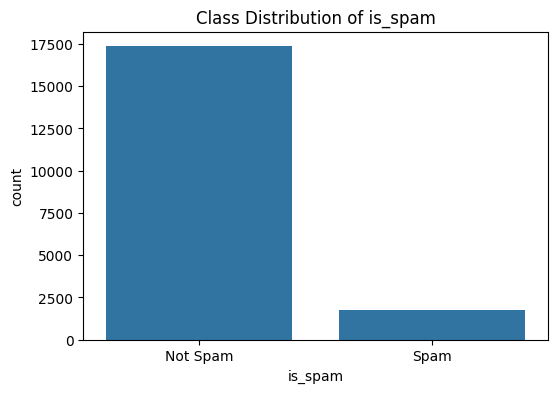

In [10]:
# check target balance
counts = train_df['is_spam'].value_counts()

# Bar plot
plt.figure(figsize=(6, 4))
sns.barplot(x=counts.index, y=counts.values)

plt.title("Class Distribution of is_spam")
plt.xlabel("is_spam")
plt.ylabel("count")
plt.xticks([0, 1], labels=["Not Spam", "Spam"])
plt.show()

In [11]:
train_df['is_spam'].value_counts(normalize=True)

is_spam
0    0.908586
1    0.091414
Name: proportion, dtype: float64

- may handle using smote later

**features distribution**

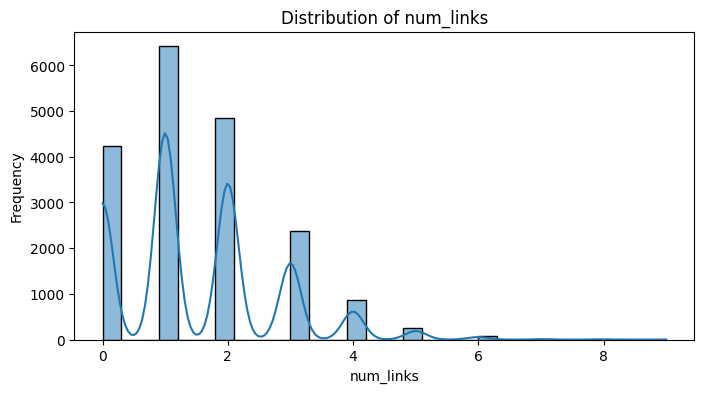

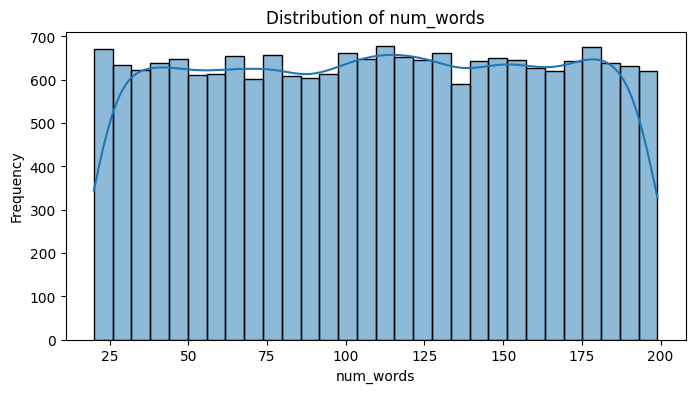

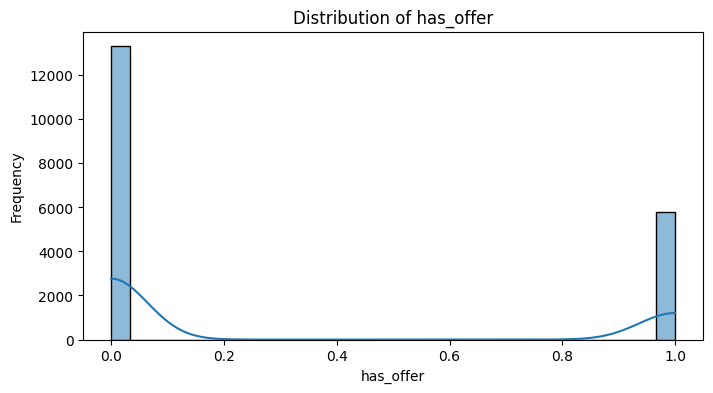

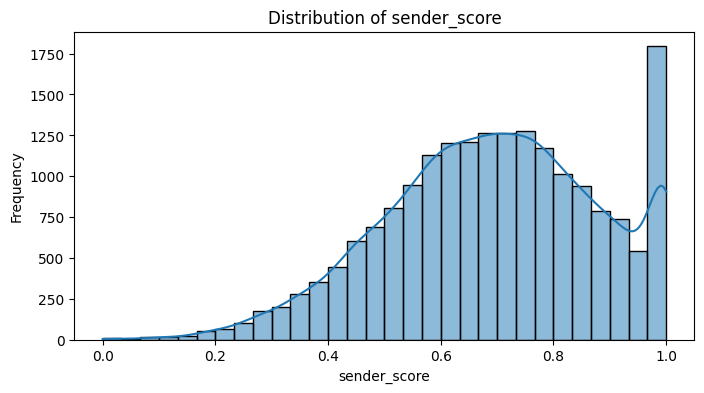

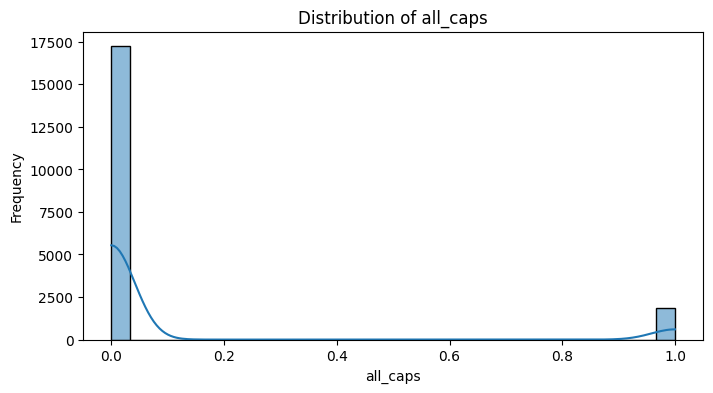

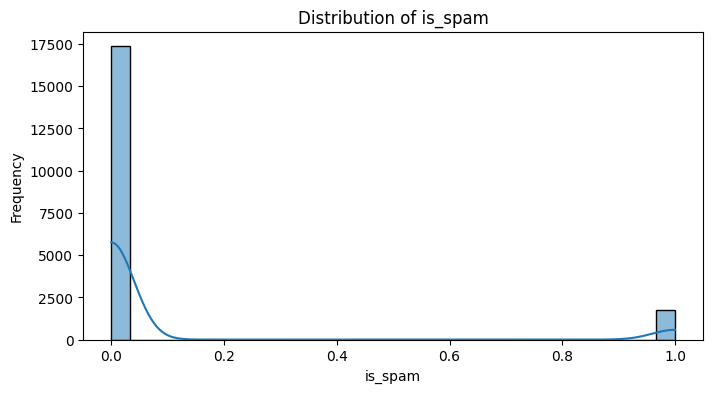

In [12]:
# List of features to visualize (numerical)
num_features = train_df.select_dtypes(include=[np.number]).columns.tolist()

# Plot distribution for each numerical feature
for feature in num_features:
    plt.figure(figsize=(8, 4))
    sns.histplot(train_df[feature], kde=True, bins=30)
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Frequency')
    plt.show()

In [13]:
# chech for duplicates
train_df.duplicated().sum()

np.int64(379)

- duplicates must be checked after removing id column 

In [14]:
train_df.shape

(19100, 6)

In [15]:
# drop duplicates
train_df = train_df.drop_duplicates() 
train_df.shape  

(18721, 6)

In [16]:
# Select numerical columns excluding target and categorical
numeric_cols = ['num_links', 'num_words', 'sender_score']
numeric_df = train_df[numeric_cols]

# IQR-based outlier detection
for col in numeric_cols:
    Q1 = numeric_df[col].quantile(0.25)
    Q3 = numeric_df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = numeric_df[(numeric_df[col] < lower_bound) | (numeric_df[col] > upper_bound)]
    print(f"{col}: {len(outliers)} outliers")


num_links: 1223 outliers
num_words: 0 outliers
sender_score: 67 outliers


**outliers handling**

In [17]:
def detect_outliers_zscore(df, columns, threshold=2.5):
    outlier_counts = {}
    for col in columns:
        z_scores = np.abs((df[col] - df[col].mean()) / df[col].std())
        outlier_counts[col] = (z_scores > threshold).sum()
    return outlier_counts

# Columns to check
cols_to_check = ['num_links', 'num_words']

# Just detect (don’t overwrite train_df)
outlier_counts = detect_outliers_zscore(train_df, cols_to_check)
print("Z-score outliers per column:", outlier_counts)

Z-score outliers per column: {'num_links': np.int64(357), 'num_words': np.int64(0)}


In [18]:
def remove_outliers_zscore(df, columns, threshold=2.5):
    outlier_mask = pd.Series(False, index=df.index)  # initialize mask
    for col in columns:
        z_scores = np.abs((df[col] - df[col].mean()) / df[col].std())
        outlier_mask |= (z_scores > threshold)  # mark outliers
    df_clean = df.loc[~outlier_mask].reset_index(drop=True)
    return df_clean, outlier_mask.sum()


# Remove outliers
train_df, removed_count = remove_outliers_zscore(train_df, cols_to_check, threshold=2.5)
print(f"Removed {removed_count} outliers. Train set shape: {train_df.shape}")


Removed 357 outliers. Train set shape: (18364, 6)


In [19]:
train_df.columns

Index(['num_links', 'num_words', 'has_offer', 'sender_score', 'all_caps',
       'is_spam'],
      dtype='object')

In [20]:
train_df.shape

(18364, 6)

### `Feature Engineering`

In [21]:
# Binary flag: very short message
train_df["short_message"] = (train_df["num_words"] < 5).astype(int)
# Log transform slightly skewed feature
train_df['sender_score'] = np.sqrt(train_df['sender_score'])

In [22]:
train_df['links_x_caps'] = train_df['num_links'] * train_df['all_caps']

In [23]:
def add_features(df):
    if "has_offer" in df.columns and "num_links" in df.columns:
        df["offer_many_links"] = ((df["has_offer"] == 1) & (df["num_links"] > 2)).astype(int)
    if "all_caps" in df.columns and "num_links" in df.columns:
        df["caps_with_links"] = ((df["all_caps"] == 1) & (df["num_links"] > 1)).astype(int)
    if "num_links" in df.columns and "num_words" in df.columns:
        df["links_per_word"] = df["num_links"] / (df["num_words"] + 1e-6)

    for col in ["num_words", "num_links"]:
        if col in df.columns:
            df[f"log_{col}"] = np.log1p(df[col])
    return df

#train_df = add_features(train_df)   # was a trial

### `prepare data`

In [24]:
X = train_df.drop('is_spam', axis=1).values
y = train_df['is_spam'].values

In [25]:
len(X)

18364

In [26]:
train_df.head()

,num_links,num_words,has_offer,sender_score,all_caps,is_spam,short_message,links_x_caps
0,3,98,1,0.847707,0,0,0,0
1,0,170,0,0.836003,1,0,0,0
2,0,38,0,0.787696,0,0,0,0
3,0,116,0,0.837708,0,0,0,0
4,3,89,1,0.763951,1,1,0,3


**introduce non-linearity**

In [27]:
poly = PolynomialFeatures(degree=4, include_bias=False)
X_poly = poly.fit_transform(X)

In [28]:
X_train, X_val, y_train, y_val = train_test_split(X_poly, y, test_size=0.2, random_state=42, stratify=y)

### `preprocessing`

In [29]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

In [30]:
X_train.shape

(14691, 329)

### `train logestic regression`

In [ ]:
model = LogisticRegression(
    learning_rate=0.1,
    iterations=2000,
    lambda_=0.01,
    regularization="l1",  # options: l1, l2, or None
    no_of_batches=1,      # batch, mini-batch, or SGD (use len(X_train))
    verbose=True
)

model.fit(X_train, y_train)

Epoch 0/2000 - Loss: 0.607565
Epoch 100/2000 - Loss: 0.198461
Epoch 200/2000 - Loss: 0.160422
Epoch 300/2000 - Loss: 0.148333
Epoch 400/2000 - Loss: 0.142499
Epoch 500/2000 - Loss: 0.139031
Epoch 600/2000 - Loss: 0.136696
Epoch 700/2000 - Loss: 0.134989
Epoch 800/2000 - Loss: 0.133665
Epoch 900/2000 - Loss: 0.132593
Epoch 1000/2000 - Loss: 0.131697
Epoch 1100/2000 - Loss: 0.130930
Epoch 1200/2000 - Loss: 0.130262
Epoch 1300/2000 - Loss: 0.129670
Epoch 1400/2000 - Loss: 0.129141
Epoch 1500/2000 - Loss: 0.128662
Epoch 1600/2000 - Loss: 0.128226
Epoch 1700/2000 - Loss: 0.127826
Epoch 1800/2000 - Loss: 0.127457
Epoch 1900/2000 - Loss: 0.127114


In [32]:
y_pred = model.predict(X_val, threshold=0.5)  # Adjust threshold as needed
print("Validation Accuracy:", accuracy_score(y_val, y_pred))
print("Validation F1 Score:", f1_score(y_val, y_pred))

Validation Accuracy: 0.9539885652055541
Validation F1 Score: 0.7206611570247934


In [33]:
print("\nConfusion Matrix:\n", confusion_matrix(y_val, y_pred))
print("\nClassification Report:\n", classification_report(y_val, y_pred))


Confusion Matrix:
 [[3286   60]
 [ 109  218]]

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.98      0.97      3346
           1       0.78      0.67      0.72       327

    accuracy                           0.95      3673
   macro avg       0.88      0.82      0.85      3673
weighted avg       0.95      0.95      0.95      3673



---

### `train on entire train.csv`

In [34]:
train_df.shape

(18364, 8)

In [ ]:
X = train_df.drop('is_spam', axis=1).values
y = train_df['is_spam'].values

poly = PolynomialFeatures(degree=4, include_bias=False)
X_poly = poly.fit_transform(X)

final_scaler = StandardScaler()    # new scaler to avoid data leakage
X_scaled = final_scaler.fit_transform(X_poly)

final_model = LogisticRegression(
    learning_rate=0.1,
    iterations=2000,
    lambda_=0.01,
    regularization="l1",  
    no_of_batches=1,    
    verbose=True
)

final_model.fit(X_scaled, y)

Epoch 0/2000 - Loss: 0.595020
Epoch 100/2000 - Loss: 0.201204
Epoch 200/2000 - Loss: 0.161501
Epoch 300/2000 - Loss: 0.147704
Epoch 400/2000 - Loss: 0.142465
Epoch 500/2000 - Loss: 0.138499
Epoch 600/2000 - Loss: 0.135825
Epoch 700/2000 - Loss: 0.133838
Epoch 800/2000 - Loss: 0.132276
Epoch 900/2000 - Loss: 0.130997
Epoch 1000/2000 - Loss: 0.129921
Epoch 1100/2000 - Loss: 0.128995
Epoch 1200/2000 - Loss: 0.128186
Epoch 1300/2000 - Loss: 0.127469
Epoch 1400/2000 - Loss: 0.126827
Epoch 1500/2000 - Loss: 0.126246
Epoch 1600/2000 - Loss: 0.125717
Epoch 1700/2000 - Loss: 0.125233
Epoch 1800/2000 - Loss: 0.124785
Epoch 1900/2000 - Loss: 0.124371


### `submission`

In [37]:
test_df = pd.read_csv(os.path.join(os.getcwd(), "data", "test.csv"))     # Kaggle test data (for submission)
test_df = test_df.drop(columns=['message_id'])



# Binary flag: very short message
test_df["short_message"] = (test_df["num_words"] < 5).astype(int)
# Log transform slightly skewed feature
test_df['sender_score'] = np.sqrt(test_df['sender_score'])
test_df['links_x_caps'] = test_df['num_links'] * test_df['all_caps']

#test_df = add_features(test_df)
X_test_final = test_df.values

X_test_final = poly.transform(X_test_final)
X_test_final = final_scaler.transform(X_test_final)
test_pred_proba = final_model.predict_proba(X_test_final)

submission_df = pd.DataFrame({
    "message_id": pd.read_csv(os.path.join(os.getcwd(), "data", "test.csv"))["message_id"],
    "is_spam": test_pred_proba
})

submission_path = os.path.join(os.getcwd(), "output", "submission.csv")
submission_df.to_csv(submission_path, index=False)
print(f"Submission file saved to {submission_path}")

Submission file saved to c:\Users\laphouse\Projects\MIA\MIA_phase1\Block3\task3.1\output\submission.csv
